In [1]:
import torch 
from torch import nn

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
device

'cuda'

# Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [5]:
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} directory not found")
    image_path.mkdir(parents = True, exist_ok  =True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists


# Data Preparation

In [6]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"] = 'TRUE'

In [8]:
walk_through_dir(image_path)

there are 2 directories and 0 images in 'data\pizza_steak_sushi'
there are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
there are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
there are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
there are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
there are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
there are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
there are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
there are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"
walk_through_dir(train_dir)
print("\n\n")
walk_through_dir(test_dir)

there are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
there are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
there are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
there are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'



there are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
there are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
there are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
there are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'


Random image path:  data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class:  sushi
Image height:  408
Image width:  512


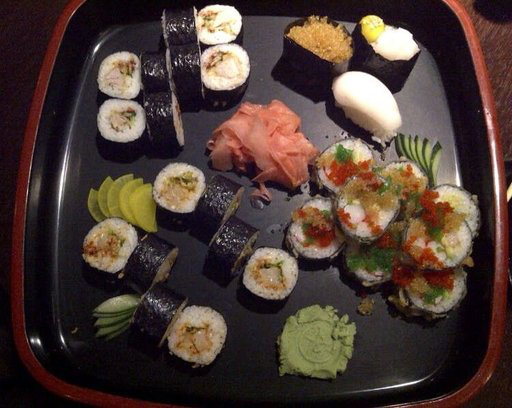

In [10]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print("Random image path: ", random_image_path)
print("Image class: ", image_class)
print("Image height: ", img.height)
print("Image width: ", img.width)
img

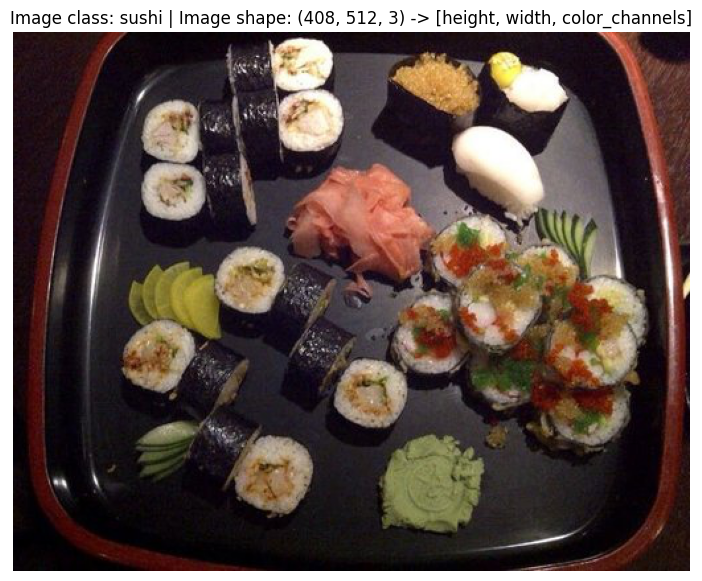

In [11]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Transforming Data

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
data_transform = transforms.Compose([transforms.Resize(size = (64, 64)), transforms.RandomHorizontalFlip(p = 0.5), transforms.ToTensor()])

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed = 42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.size}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

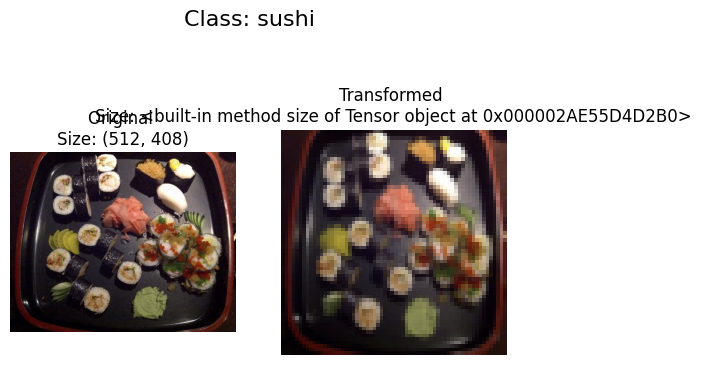

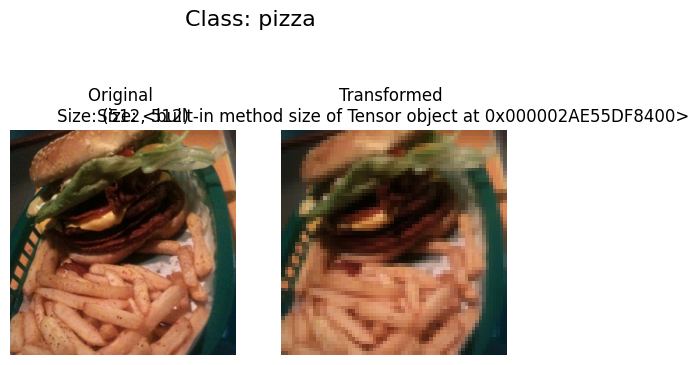

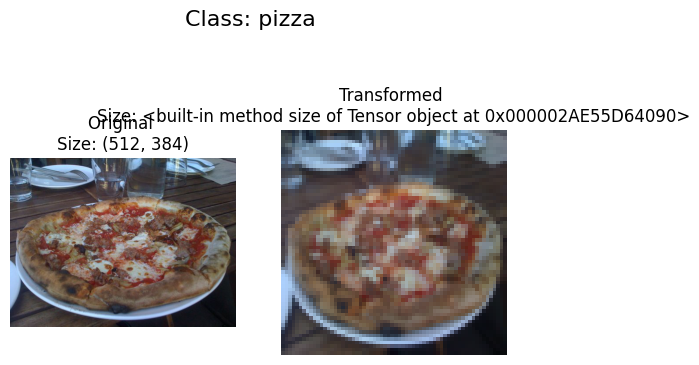

In [15]:
plot_transformed_images(image_path_list, data_transform)

# Loading Image Data using ImageFolder

In [16]:
train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform)

In [17]:
print(f"Train data:\n{train_data}\n\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [21]:
img_permute = img.permute(1, 2, 0)

print("Originial shape:", {img.shape}, "-> [chw]")
print("Image permute shape:", {img_permute.shape}, "-> [hwc]")

Originial shape: {torch.Size([3, 64, 64])} -> [chw]
Image permute shape: {torch.Size([64, 64, 3])} -> [hwc]


In [22]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 1, num_workers = 1, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = 1, num_workers = 1, shuffle = False)

In [23]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2ae55f66d70>,
 <torch.utils.data.dataloader.DataLoader at 0x2ae55f678e0>)

In [24]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Loading Image Data with a Custom Dataset

In [25]:
import os
import pathlib
import torch 

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
target_directory = train_dir
print(target_directory)

data\pizza_steak_sushi\train


In [27]:
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(class_names_found)

['pizza', 'steak', 'sushi']


In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        return FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [30]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform = None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    def load_images(self, index: int) -> Image.Image:
        img_path = self.paths[index]
        return Image.open(img_path)
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_images(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [31]:
#transform
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [32]:
#custom data loading
train_data_custom = ImageFolderCustom(targ_dir = train_dir, transform = train_transform)
test_data_custom = ImageFolderCustom(targ_dir = test_dir, transform = test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2ae55f8b9d0>,
 <__main__.ImageFolderCustom at 0x2ae55f30370>)

In [33]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [34]:
train_data_custom.class_to_idx, test_data_custom.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [35]:
(len(train_data) == len(train_data_custom)) & (len(test_data) == len(test_data_custom))

True

In [36]:
train_data_custom.classes == train_data.classes

True

In [37]:
train_data_custom.class_to_idx == train_data.class_to_idx

True

In [38]:
def display_random_image(dataset: torch.utils.data.dataset.Dataset, classes: List[str] = None, n: int = 10, display_shape: bool = True, seed: int = None):
    if n > 10:
        display_shape = False
        n = 10
    
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    plt.figure(figsize = (16, 8))
    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)
    

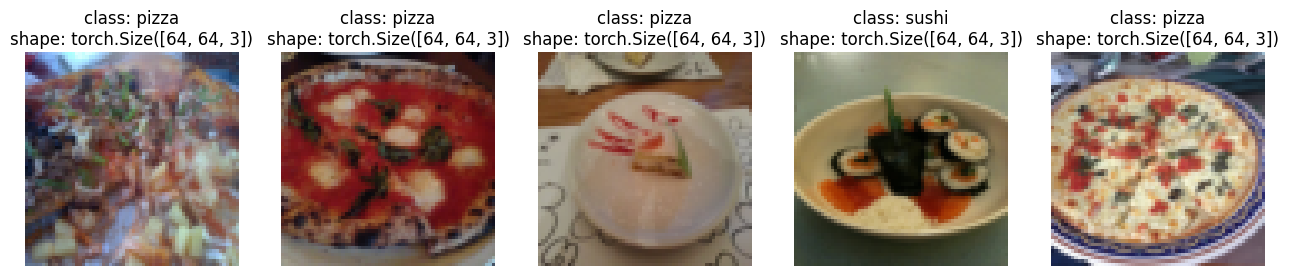

In [39]:
display_random_image(train_data, n = 5, classes = class_names, seed = None)

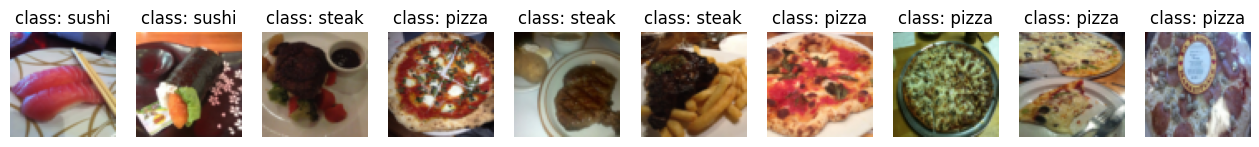

In [40]:
display_random_image(train_data, n = 16, classes = class_names, seed = None)

In [41]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(train_data_custom, batch_size = 1, num_workers = 0, shuffle = True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size = 1, num_workers = 0, shuffle = False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2ae5765d7b0>,
 <torch.utils.data.dataloader.DataLoader at 0x2ae57105de0>)

In [42]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [43]:
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

# Other forms of Transforms (Data Augmentation

In [44]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.TrivialAugmentWide(num_magnitude_bins = 31), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

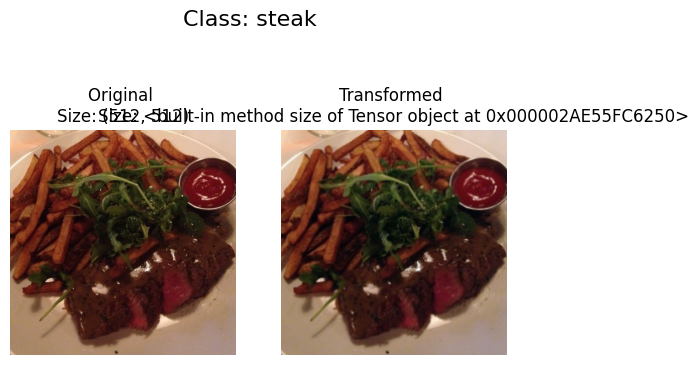

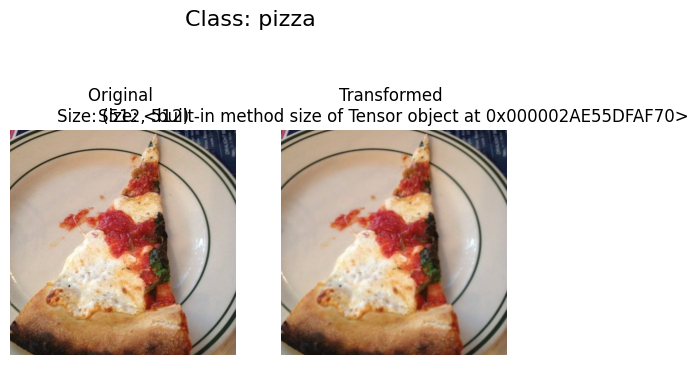

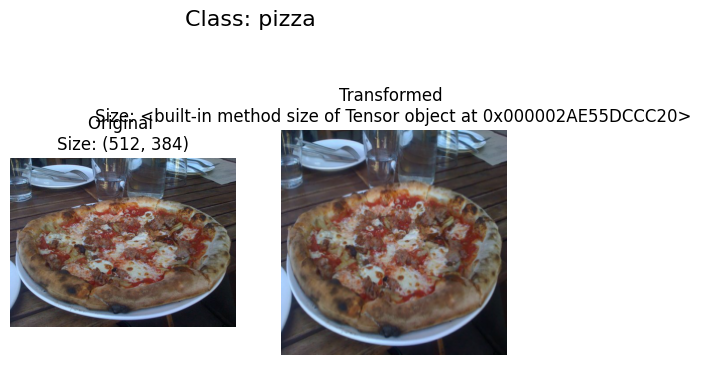

In [45]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(image_paths = image_path_list, transform = train_transforms, n = 3, seed = None)

# Model 0: Tiny VGG without data augmentation

In [46]:
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [47]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir, transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, transform = simple_transform)

In [48]:
import os
from torch.utils.data import DataLoader

batch_size = 32
num_workers = os.cpu_count()

train_dataloader_simple = DataLoader(train_data_simple, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_dataloader_simple = DataLoader(test_data_simple, batch_size = batch_size, num_workers = num_workers, shuffle = False)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x2ae55feb400>,
 <torch.utils.data.dataloader.DataLoader at 0x2ae55febd60>)

In [49]:
class TinyVGG(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_units: int) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_features, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 16 * 16, out_features = output_features),
        )
    
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

In [50]:
torch.manual_seed(42)
model_0 = TinyVGG(input_features = 3, output_features = len(train_data.classes), hidden_units = 10).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [51]:
img_batch, label_batch = next(iter(train_dataloader_simple))
img_single, label_single = img_batch[0].unsqueeze(dim = 0), label_batch[0]

In [52]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

In [53]:
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[0.0578, 0.0634, 0.0352]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [54]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [55]:
from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [56]:
def training_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [57]:
def testing_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            test_loss += loss_fn(test_pred_logits, y).item()
            test_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim = 1), dim = 1)
            test_acc += ((test_pred_class == y).sum().item()/len(test_pred_class))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

In [58]:
from helper_functions import accuracy_fn
from tqdm.auto import tqdm

In [82]:
import helper_functions 

In [83]:
dir(helper_functions)

['List',
 'Path',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'accuracy_fn',
 'download_data',
 'nn',
 'np',
 'os',
 'plot_decision_boundary',
 'plot_loss_curves',
 'plot_predictions',
 'plt',
 'pred_and_plot_image',
 'print_train_time',
 'requests',
 'set_seeds',
 'torch',
 'torchvision',
 'walk_through_dir',
 'zipfile']

In [59]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int = 5):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = testing_step(model, test_dataloader, loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

model_0 = TinyVGG(input_features = 3, output_features = len(train_data.classes), hidden_units = 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model_0, train_dataloader_simple, test_dataloader_simple, loss_fn, optimizer, epochs)
end_time = timer()
print(f"Total training time {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0975 | train_acc: 0.2500 | test_loss: 1.1055 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.0968 | train_acc: 0.3984 | test_loss: 1.1072 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0983 | train_acc: 0.2930 | test_loss: 1.1082 | test_acc: 0.1875
Epoch: 4 | train_loss: 1.0963 | train_acc: 0.3828 | test_loss: 1.1099 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0971 | train_acc: 0.2930 | test_loss: 1.1109 | test_acc: 0.1667
Epoch: 6 | train_loss: 1.0965 | train_acc: 0.2617 | test_loss: 1.1125 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1037 | train_acc: 0.2852 | test_loss: 1.1097 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1023 | train_acc: 0.2930 | test_loss: 1.1071 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1016 | train_acc: 0.2891 | test_loss: 1.1045 | test_acc: 0.1875
Epoch: 10 | train_loss: 1.1010 | train_acc: 0.2852 | test_loss: 1.1021 | test_acc: 0.1771
Total training time 225.098 seconds


In [61]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [62]:
def plot_loss_curves(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    plt.figure(figsize = (15, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

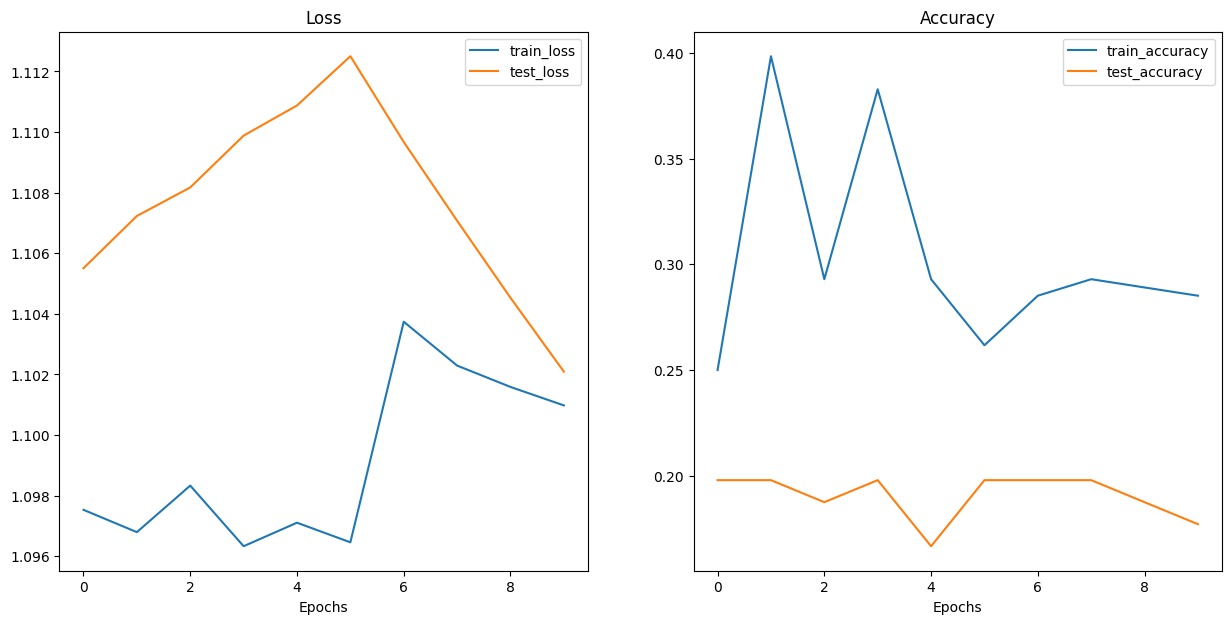

In [63]:
plot_loss_curves(model_0_results)

In [64]:
model_0_results["train_loss"]

[1.0975321382284164,
 1.0967953354120255,
 1.0983315259218216,
 1.0963305532932281,
 1.0971065014600754,
 1.0964590907096863,
 1.1037403345108032,
 1.102292686700821,
 1.1015877723693848,
 1.1009784638881683]

# Model 1: TinyVGG with Data Augmentation

In [65]:
train_transform_trivial_augment = transforms.Compose([transforms.Resize((64, 64)), transforms.TrivialAugmentWide(num_magnitude_bins = 31), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
print(train_transform_trivial_augment)
print("\n\n")
print(test_transform)

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)



Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [66]:
train_data_augmented = datasets.ImageFolder(train_dir, train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, test_transform)
print(train_data_augmented)
print("\n\n")
print(test_data_simple)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )



Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [67]:
import os
batch_size = 32
num_workers = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_dataloader_simple = DataLoader(test_data_simple, batch_size = batch_size, num_workers = num_workers, shuffle = False)
train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x2ae2d387640>,
 <torch.utils.data.dataloader.DataLoader at 0x2ae2b689570>)

In [68]:
torch.manual_seed(42)
model_1 = TinyVGG(input_features = 3, output_features = len(train_data_augmented.classes), hidden_units = 10).to(device)
model_1

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.001)

from timeit import default_timer as timer 
start_time = timer()

model_1_results = train(model_1, train_dataloader_augmented, test_dataloader_simple, loss_fn, optimizer, epochs)
end_time = timer()
print(f"Total training time {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.2617 | test_loss: 1.1049 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0963 | train_acc: 0.4258 | test_loss: 1.1060 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0948 | train_acc: 0.4258 | test_loss: 1.1072 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3047 | test_loss: 1.1088 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0943 | train_acc: 0.4258 | test_loss: 1.1099 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0982 | train_acc: 0.3047 | test_loss: 1.1115 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0976 | train_acc: 0.3047 | test_loss: 1.1130 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.0942 | train_acc: 0.4258 | test_loss: 1.1140 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1042 | train_acc: 0.3047 | test_loss: 1.1111 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.0939 | train_acc: 0.4258 | test_loss: 1.1123 | test_acc: 0.2604
Total training time 178.526 seconds


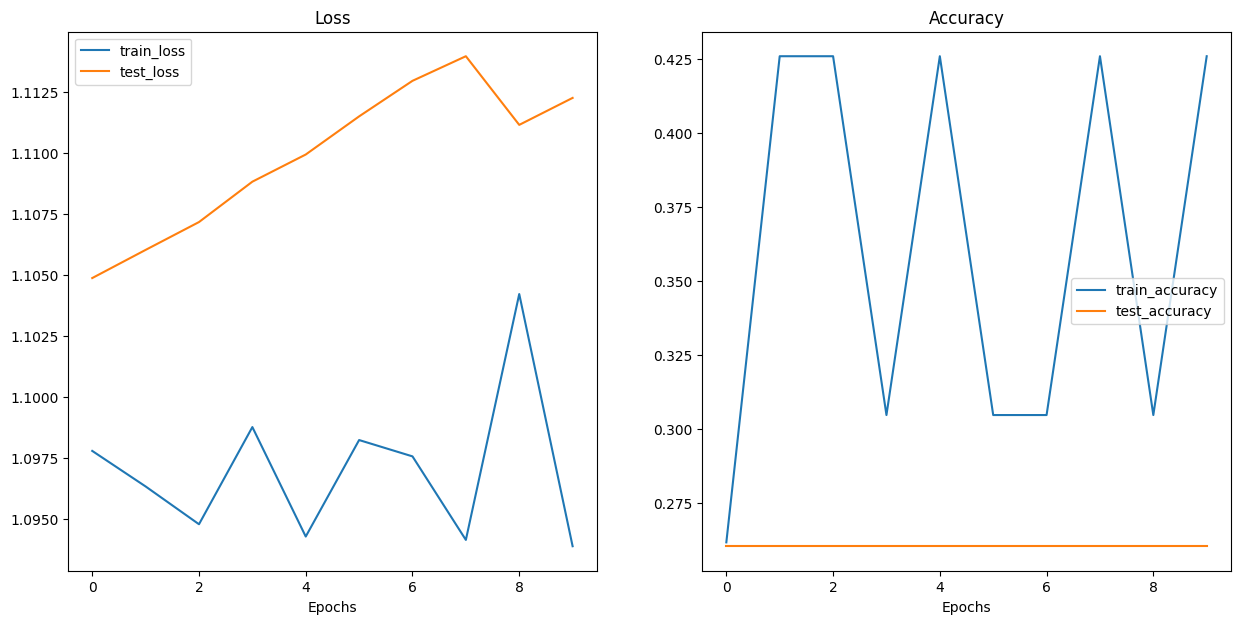

In [70]:
plot_loss_curves(model_1_results)

In [71]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.097532   0.250000   1.105507  0.197917
 1    1.096795   0.398438   1.107230  0.197917
 2    1.098332   0.292969   1.108172  0.187500
 3    1.096331   0.382812   1.109883  0.197917
 4    1.097107   0.292969   1.110878  0.166667
 5    1.096459   0.261719   1.112504  0.197917
 6    1.103740   0.285156   1.109673  0.197917
 7    1.102293   0.292969   1.107072  0.197917
 8    1.101588   0.289062   1.104530  0.187500
 9    1.100978   0.285156   1.102093  0.177083,
    train_loss  train_acc  test_loss  test_acc
 0    1.097798   0.261719   1.104875  0.260417
 1    1.096342   0.425781   1.106028  0.260417
 2    1.094795   0.425781   1.107168  0.260417
 3    1.098774   0.304688   1.108821  0.260417
 4    1.094291   0.425781   1.109934  0.260417
 5    1.098243   0.304688   1.111495  0.260417
 6    1.097574   0.304688   1.112951  0.260417
 7    1.094154   0.425781   1.113958  0.260417
 8    1.104221   0.304688   1.111147  0.260417
 9    1.0938

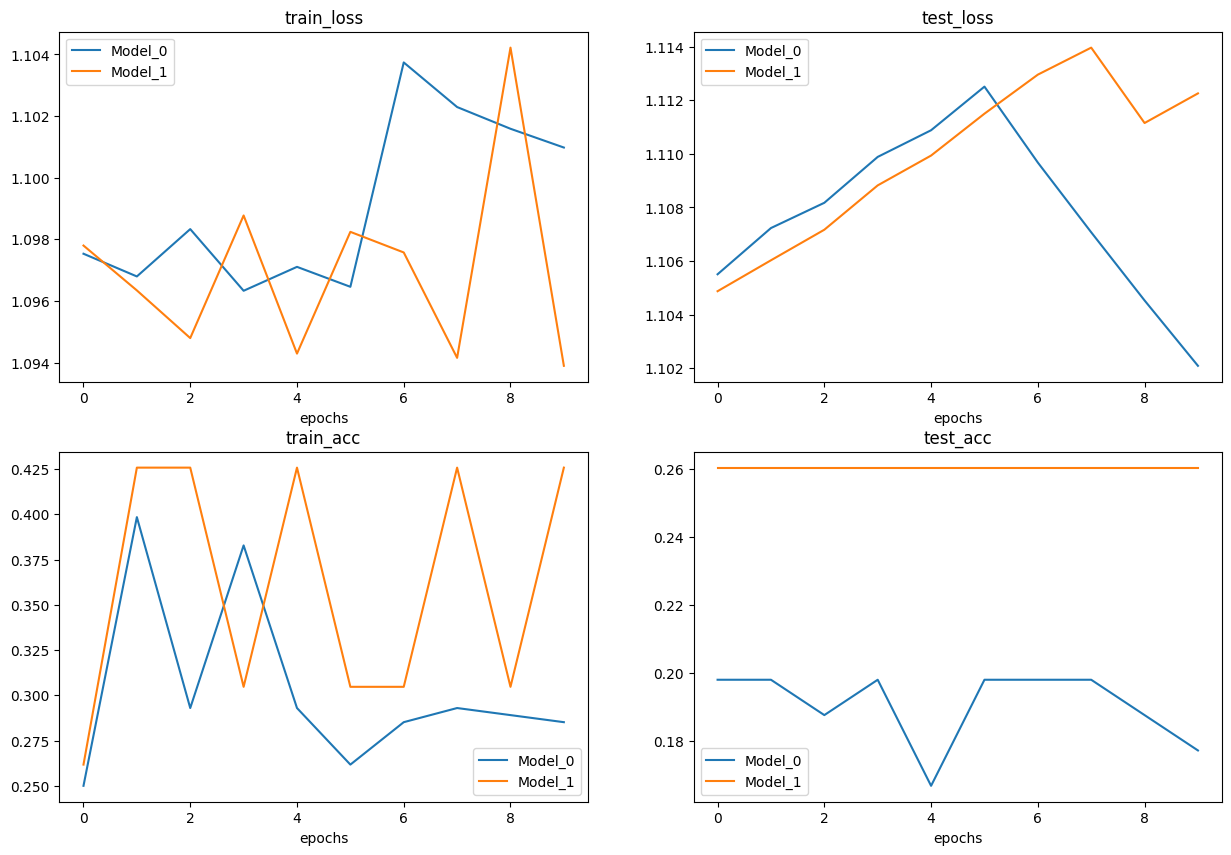

In [72]:
plt.figure(figsize = (15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model_1")
plt.title("train_loss")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model_1")
plt.title("test_loss")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model_1")
plt.title("train_acc")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model_1")
plt.title("test_acc")
plt.xlabel("epochs")
plt.legend()

In [73]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print("Downloading")
        f.write(request.content)
else:
    print("already Downloaded")

already Downloaded


In [74]:
import torchvision

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [75]:
custom_image_transform = transforms.Compose([transforms.Resize((64, 64))])
custom_image_transformed = custom_image_transform(custom_image)
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


C:\Users\ppamr\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [76]:
model_1.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [77]:
print("Prediction logits:", custom_image_pred)
custom_image_pred_prob = torch.softmax(custom_image_pred, dim = 1)
print("Prediction Probability:", custom_image_pred_prob)
custom_image_pred_label = torch.argmax(custom_image_pred_prob, dim = 1)
print("Prediction Label:", custom_image_pred_label)

Prediction logits: tensor([[0.1036, 0.0607, 0.0098]], device='cuda:0')
Prediction Probability: tensor([[0.3486, 0.3340, 0.3174]], device='cuda:0')
Prediction Label: tensor([0], device='cuda:0')


In [78]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

In [79]:
custom_image_pred_prob

tensor([[0.3486, 0.3340, 0.3174]], device='cuda:0')

In [80]:
def pred_and_plot_image(model: torch.nn.Module, image_path: str, class_names: List[str] = None, transform=None, device: torch.device = device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255. 
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

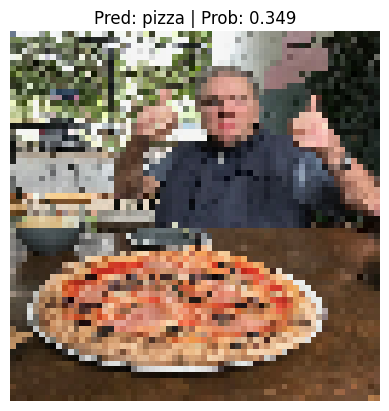

In [81]:
pred_and_plot_image(model_1, custom_image_path, class_names, custom_image_transform, device)